In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

In [96]:
print(os.getcwd())

/Users/rihaansatia/Desktop/Projects/earningsAnalysis/earnings-call-market-prediction/notebooks


In [98]:
sys.path.append('../src')
plt.style.use('default')
sns.set_palette("husl")

In [100]:
# Load raw data
data_dir = Path('../data/raw')

transcripts = pd.read_csv(data_dir / 'earnings_calls_transcripts.csv')
sentiment = pd.read_csv(data_dir / 'earnings_calls_transcript_sentiment.csv')
prices = pd.read_csv(data_dir / 'earnings_calls_stock_prices.csv')

### Data Exploration

In [21]:
transcripts.head()

,company,date,transcript
0,AMD,2016-07-21,\n\nThomson Reuters StreetEvents Event Transcr...
1,AMD,2019-10-29,\n\nThomson Reuters StreetEvents Event Transcr...
2,AAPL,2019-04-30,\n\nThomson Reuters StreetEvents Event Brief\n...
3,AAPL,2016-10-25,\n\nThomson Reuters StreetEvents Event Brief\n...
4,INTC,2016-10-18,\n\nThomson Reuters StreetEvents Event Transcr...


In [24]:
sentiment.head()

,text,label,company,date,para_no
0,"* Lisa Su Advanced Micro Devices, Inc. - Pr...",positive,AMD,2016-07-21,4
1,* Matt Ramsay Canaccord Genuity - Analyst ...,positive,AMD,2016-07-21,6
2,==============================================...,positive,AMD,2016-07-21,7
3,"Ruth Cotter, Advanced Micro Devices, Inc. - ...",positive,AMD,2016-07-21,8
4,"Lisa Su, Advanced Micro Devices, Inc. - Pres...",positive,AMD,2016-07-21,9


In [30]:
prices.head()

,date,open,high,low,close,adj_close,volume,company
0,2016-01-04,656.29,657.72,627.51,636.99,636.99,9314500,AMZN
1,2016-01-05,646.86,646.91,627.65,633.79,633.79,5822600,AMZN
2,2016-01-06,622.00,639.79,620.31,632.65,632.65,5329200,AMZN
3,2016-01-07,621.80,630.00,605.21,607.94,607.94,7074900,AMZN
4,2016-01-08,619.66,624.14,606.00,607.05,607.05,5512900,AMZN


In [32]:
print(f"Transcripts: {transcripts.shape}")
print(f"Sentiment: {sentiment.shape}")
print(f"Prices: {prices.shape}")

Transcripts: (150, 3)
Sentiment: (6851, 5)
Prices: (13155, 8)


In [34]:
# Dataset overview
transcripts['date'] = pd.to_datetime(transcripts['date'])
sentiment['date'] = pd.to_datetime(sentiment['date'])
prices['date'] = pd.to_datetime(prices['date'])

print("=== TRANSCRIPTS ===")
print(f"Companies: {transcripts['company'].nunique()}")
print(f"Date range: {transcripts['date'].min()} to {transcripts['date'].max()}")
print(f"Companies: {transcripts['company'].unique()}")

=== TRANSCRIPTS ===
Companies: 10
Date range: 2016-01-14 00:00:00 to 2020-08-19 00:00:00
Companies: ['AMD' 'AAPL' 'INTC' 'MU' 'GOOGL' 'ASML' 'CSCO' 'NVDA' 'AMZN' 'MSFT']


In [36]:
print("\n=== SENTIMENT ===")
print(f"Companies: {sentiment['company'].nunique()}")
print(f"Date range: {sentiment['date'].min()} to {sentiment['date'].max()}")
print(f"Sentiment labels: {sentiment['label'].value_counts().to_dict()}")


=== SENTIMENT ===
Companies: 10
Date range: 2016-01-14 00:00:00 to 2020-08-19 00:00:00
Sentiment labels: {'positive': 3950, 'negative': 2901}


In [38]:
print("\n=== PRICES ===")
print(f"Companies: {prices['company'].nunique()}")
print(f"Date range: {prices['date'].min()} to {prices['date'].max()}")


=== PRICES ===
Companies: 11
Date range: 2016-01-04 00:00:00 to 2020-10-01 00:00:00


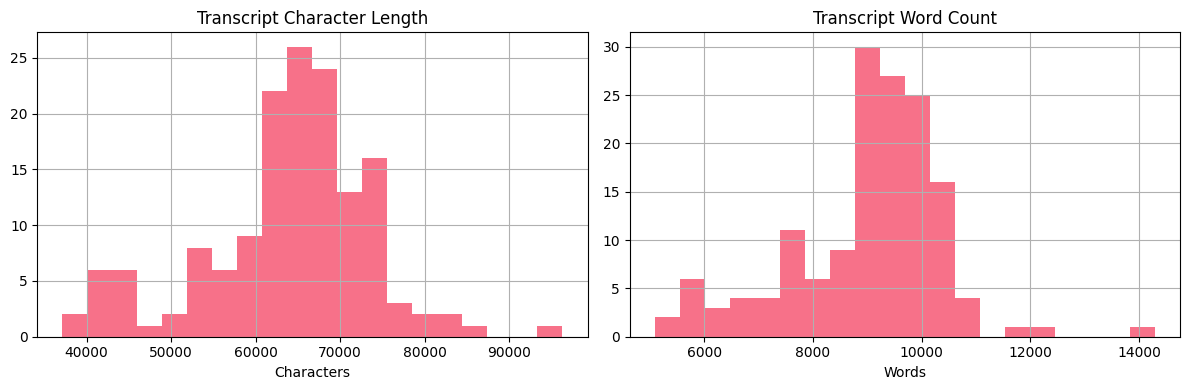

In [40]:
# Transcript analysis
transcripts['transcript_length'] = transcripts['transcript'].str.len()
transcripts['word_count'] = transcripts['transcript'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

transcripts['transcript_length'].hist(bins=20, ax=axes[0])
axes[0].set_title('Transcript Character Length')
axes[0].set_xlabel('Characters')

transcripts['word_count'].hist(bins=20, ax=axes[1])
axes[1].set_title('Transcript Word Count')
axes[1].set_xlabel('Words')

plt.tight_layout()
plt.show()

In [42]:
print(f"Avg transcript length: {transcripts['transcript_length'].mean():.0f} chars")
print(f"Avg word count: {transcripts['word_count'].mean():.0f} words")

Avg transcript length: 63928 chars
Avg word count: 9010 words


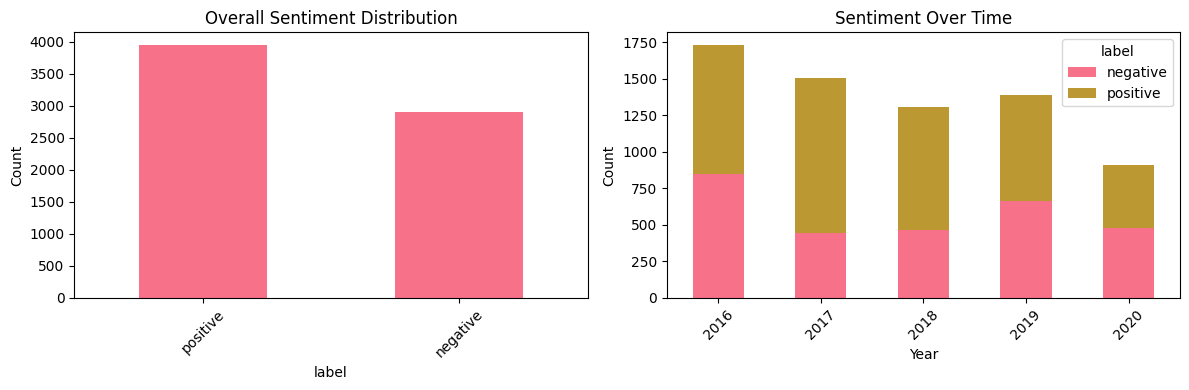

In [46]:
# Sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sentiment['label'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Overall Sentiment Distribution')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sentiment_time = sentiment.groupby([sentiment['date'].dt.year, 'label']).size().unstack(fill_value=0)
sentiment_time.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Sentiment Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [48]:
# Stock price analysis
prices_analysis = prices.copy()
prices_analysis = prices_analysis.sort_values(['company', 'date'])
prices_analysis['daily_return'] = prices_analysis.groupby('company')['adj_close'].pct_change()
prices_analysis['volatility'] = prices_analysis.groupby('company')['daily_return'].rolling(10).std().reset_index(0, drop=True)

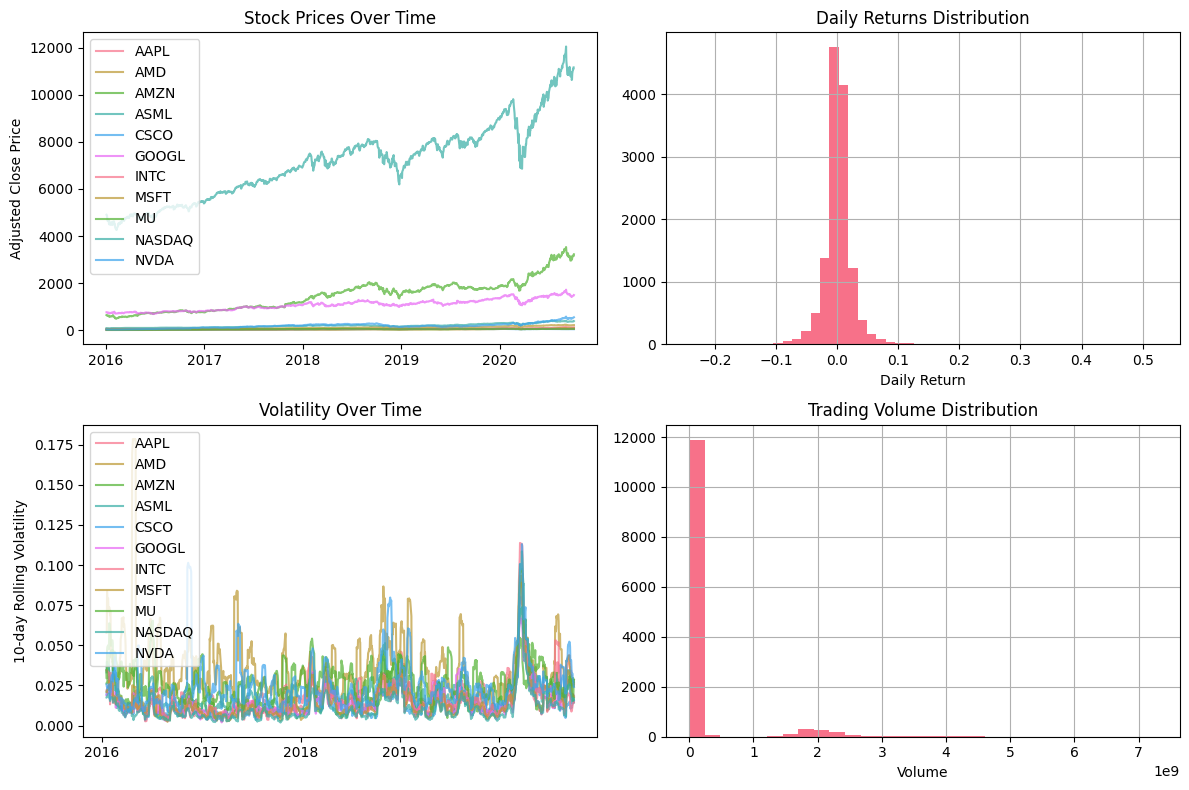

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for company in prices_analysis['company'].unique():
  company_data = prices_analysis[prices_analysis['company'] == company]
  axes[0,0].plot(company_data['date'], company_data['adj_close'], label=company, alpha=0.7)
axes[0,0].set_title('Stock Prices Over Time')
axes[0,0].set_ylabel('Adjusted Close Price')
axes[0,0].legend()

prices_analysis['daily_return'].dropna().hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Daily Returns Distribution')
axes[0,1].set_xlabel('Daily Return')

for company in prices_analysis['company'].unique():
  company_data = prices_analysis[prices_analysis['company'] == company]
  axes[1,0].plot(company_data['date'], company_data['volatility'], label=company, alpha=0.7)
axes[1,0].set_title('Volatility Over Time')
axes[1,0].set_ylabel('10-day Rolling Volatility')
axes[1,0].legend()

prices_analysis['volume'].hist(bins=30, ax=axes[1,1])
axes[1,1].set_title('Trading Volume Distribution')
axes[1,1].set_xlabel('Volume')

plt.tight_layout()
plt.show()

In [56]:
print("=== DATA COVERAGE ===")

transcript_companies = set(transcripts['company'].unique())
sentiment_companies = set(sentiment['company'].unique())
price_companies = set(prices['company'].unique())
print(f"Companies in transcripts: {transcript_companies}")
print(f"Companies in sentiment: {sentiment_companies}")
print(f"Companies in prices: {price_companies}")
all_three = transcript_companies & sentiment_companies & price_companies
print(f"\nCompanies in all three datasets: {all_three}")

=== DATA COVERAGE ===
Companies in transcripts: {'INTC', 'GOOGL', 'AMZN', 'CSCO', 'NVDA', 'MU', 'ASML', 'AMD', 'AAPL', 'MSFT'}
Companies in sentiment: {'INTC', 'GOOGL', 'AMZN', 'CSCO', 'NVDA', 'MU', 'ASML', 'AMD', 'AAPL', 'MSFT'}
Companies in prices: {'INTC', 'AMZN', 'GOOGL', 'CSCO', 'NVDA', 'MU', 'NASDAQ', 'ASML', 'AMD', 'AAPL', 'MSFT'}

Companies in all three datasets: {'INTC', 'GOOGL', 'AMZN', 'CSCO', 'NVDA', 'MU', 'ASML', 'AMD', 'AAPL', 'MSFT'}


In [68]:
for company in all_three:
  t_dates = transcripts[transcripts['company'] == company]['date']
  s_dates = sentiment[sentiment['company'] == company]['date']
  p_dates = prices[prices['company'] == company]['date']

  t_min = t_dates.min().strftime('%Y-%m-%d') 
  t_max = t_dates.max().strftime('%Y-%m-%d') 
  s_min = s_dates.min().strftime('%Y-%m-%d') 
  s_max = s_dates.max().strftime('%Y-%m-%d') 
  print(f"\n{company}:")
  print(f"  Transcripts: {t_min} to {t_max} ({len(t_dates)} calls)")
  print(f"  Sentiment: {s_min} to {s_max} ({len(s_dates.unique())} unique dates)")


INTC:
  Transcripts: 2016-01-14 to 2020-04-23 (16 calls)
  Sentiment: 2016-01-14 to 2020-04-23 (16 unique dates)

GOOGL:
  Transcripts: 2016-02-01 to 2020-07-30 (14 calls)
  Sentiment: 2016-02-01 to 2020-07-30 (14 unique dates)

AMZN:
  Transcripts: 2016-01-28 to 2020-07-30 (18 calls)
  Sentiment: 2016-01-28 to 2020-07-30 (18 unique dates)

CSCO:
  Transcripts: 2016-05-18 to 2020-08-12 (13 calls)
  Sentiment: 2016-05-18 to 2020-08-12 (13 unique dates)

NVDA:
  Transcripts: 2016-02-17 to 2020-08-19 (16 calls)
  Sentiment: 2016-02-17 to 2020-08-19 (16 unique dates)

MU:
  Transcripts: 2016-03-30 to 2020-03-25 (15 calls)
  Sentiment: 2016-03-30 to 2020-03-25 (15 unique dates)

ASML:
  Transcripts: 2016-01-20 to 2020-07-15 (15 calls)
  Sentiment: 2016-01-20 to 2020-07-15 (15 unique dates)

AMD:
  Transcripts: 2016-01-19 to 2020-07-28 (17 calls)
  Sentiment: 2016-01-19 to 2020-07-28 (17 unique dates)

AAPL:
  Transcripts: 2016-04-26 to 2020-07-30 (14 calls)
  Sentiment: 2016-04-26 to 2020-

In [72]:
sample_transcript

company                                                            AMD
date                                               2016-07-21 00:00:00
transcript           \n\nThomson Reuters StreetEvents Event Transcr...
transcript_length                                                67500
word_count                                                        8942
Name: 0, dtype: object

In [84]:
# Sample transcript analysis
sample_transcript = transcripts.iloc[0]
print(f"Company: {sample_transcript['company']}")
print(f"Date: {sample_transcript['date']}")

print(f"\nFirst 5000 characters:")
print(sample_transcript['transcript'][:5000])

Company: AMD
Date: 2016-07-21 00:00:00

First 5000 characters:


Thomson Reuters StreetEvents Event Transcript
E D I T E D   V E R S I O N

Q2 2016 Advanced Micro Devices Inc Earnings Call
JULY 21, 2016 / 9:00PM GMT

Corporate Participants

 * Lisa Su
   Advanced Micro Devices, Inc. - President and CEO
 * Devinder Kumar
   Advanced Micro Devices, Inc. - SVP, CFO and Treasurer
 * Ruth Cotter
   Advanced Micro Devices, Inc. - Chief Human Resources Officer and SVP of Corporate Communications and IR

Conference Call Participiants

 * Matt Ramsay
   Canaccord Genuity - Analyst
 * Jaguar Bajwa
   Arete Research - Analyst
 * Gabriel Ho
   BMO Capital Markets - Analyst
 * Mark Lipacis
   Jefferies LLC - Analyst
 * Stacy Rasgon
   Bernstein Research - Analyst
 * David Wong
   Wells Fargo Securities, LLC - Analyst
 * Marco Chan
   Citigroup - Analyst
 * Ian Ing
   MKM Partners - Analyst
 * Sidney Ho
   Deutsche Bank - Analyst
 * Joe Moore
   Morgan Stanley - Analyst
 * John Pitzer
   Credit Suis

In [92]:
same_call_sentiment = sentiment[(sentiment['company'] == sample_transcript['company']) &(sentiment['date'] == sample_transcript['date'])]
print(f"\nSentiment paragraphs for this call: {len(same_call_sentiment)}")
print(same_call_sentiment['label'].value_counts())


Sentiment paragraphs for this call: 68
label
positive    68
Name: count, dtype: int64


In [90]:
print(f"Total earnings calls: {len(transcripts)}")
print(f"Total sentiment paragraphs: {len(sentiment)}")
print(f"Stock price data points: {len(prices)}")

returns = prices_analysis['daily_return'].dropna()
volatility = prices_analysis['volatility'].dropna()

high_vol_threshold = volatility.quantile(0.75)
high_return_threshold = 0.02

print(f"High volatility threshold (75th percentile): {high_vol_threshold:.4f}")
print(f"Significant return threshold: ±{high_return_threshold:.1%}")
print(f"Days with high volatility: {(volatility > high_vol_threshold).sum()} ({(volatility > high_vol_threshold).mean():.1%})")
print(f"Days with significant returns: {(returns.abs() > high_return_threshold).sum()} ({(returns.abs() > 
high_return_threshold).mean():.1%})")

Total earnings calls: 150
Total sentiment paragraphs: 6851
Stock price data points: 13155
High volatility threshold (75th percentile): 0.0244
Significant return threshold: ±2.0%
Days with high volatility: 3261 (25.0%)
Days with significant returns: 3138 (23.9%)
